In [1]:
import os
os.chdir(r"C:\Users\Eduardo\Documents\CARRERA\Udemy\deep_learning\course_2\week5\Regularization")

# Regularization

Deep Learning models have so much flexibility and capacity that **overfitting can be a serious problem**, if the training dataset is not big enough. Sure it does well on the training set, but the learned network **doesn't generalize to new examples** that it has never seen!<br>
In this Notebook we will cover and compare:
* **Unregularized Gradient Descent**
* **L2 Norm (Forbenuis Norm Regularization) Gradient Descent**
* **Dropout regularization Gradient Descent**



In [2]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from reg_utils import load_2D_dataset, predict_dec
import sklearn
import sklearn.datasets
import scipy.io
from testCases import *

In [100]:
# colors for print()
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

print(color.BLUE + "6/20/2020"+ color.END)

6/20/2020


### 1. Load Dataset:

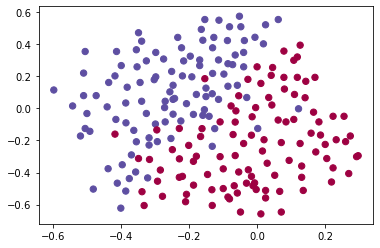

In [4]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

## Getting to know the Dataset

In [5]:
m_train= train_X.shape[1]
m_test = test_X.shape[1] 
print("SUMMARY OF DATA SET: \n")
print("size of trainning data: ",m_train)
print("size of test data: ",m_test,"\n")

print("X_train:",train_X.shape,"y_train",train_Y.shape)
print("X_test:",test_X.shape,"y_test",test_Y.shape)

SUMMARY OF DATA SET: 

size of trainning data:  211
size of test data:  200 

X_train: (2, 211) y_train (1, 211)
X_test: (2, 200) y_test (1, 200)


# Intialization: 
For this examples we will Use Xavier Initalization, which is similar to He 

Xavier: $ \frac{1}{\sqrt{ l - 1}} $

He:  $ \sqrt{\frac{2}{l - 1}} $

In [15]:
def initialize_parameters_xavier(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    Xavier = 1/sqrt(l-1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

    return parameters

## Activation Function Library 

In [16]:
#Activation Functions:
def Sigmoid(Z):
    s = 1/(1+np.exp(-Z))
    return s

def ReLU(Z):
    return Z * (Z > 0)

# Derivatives of Activation Functions:

def dSigmoid(A):
    return A*(1-A)

def dReLU(Z):
    return 1. * (Z > 0)

# Decision_boundary

In [17]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()
    

In [18]:
learning_rate = 0.3

# 1 - Non-regularized model

In [26]:
layers_dims = [train_X.shape[0], 20, 3, 1]
parameters = initialize_parameters_xavier(layers_dims)
print("Neural Net Architecture:",layers_dims)

Neural Net Architecture: [2, 20, 3, 1]


Non-regularized model

Accuracy on Train data: 93.8388625592417 %
Accuaracy on Test data: 91.5 %


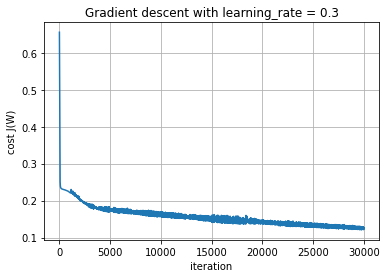

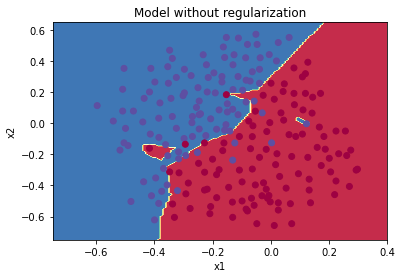

In [27]:
m=m_train
costs = []
for iteration in range(0,30000):


    #Activation Topology:

    Activations=["ReLU","ReLU","Sigmoid"] # L-1 Activations

    ##feedforward wit for: 

    forward = {}
    forward["A" + str(0)] =train_X

    for i in range(1,len(layers_dims)):
        forward["Z" + str(i)] =  parameters["W"+ str(i)].dot(forward["A" + str(i-1)])  + parameters["b"+ str(i)]
        if Activations[i-1] =="ReLU":
            forward["A" + str(i)] = ReLU(forward["Z" + str(i)])
        elif Activations[i-1] == "Sigmoid":
            forward["A" + str(i)] = Sigmoid(forward["Z" + str(i)])

    ###Cost


    logprobs =  train_Y* np.log(forward["A" + str(i)]) + (1-train_Y) * np.log(1- forward["A" + str(i)])
    cost = (-1/m)* np.sum(logprobs)
    costs.append(cost)


    ####Back Prop

    gradiants = {}
    # FORMAL WAY TO COMPUTE GRADIENTS FOR LAST LAYER
    #gradiants["dA" +str(i)] = - (np.divide(train_Y, forward["A" + str(i)]) - np.divide(1 - train_Y, 1 - forward["A" + str(i)]))
    #gradiants["dZ" +str(i)] = gradiants["dA" +str(i)]*dSigmoid(forward["A" + str(i)])
    # MUCH FASTER WAY ----->                    Al-Y
    gradiants["dZ" +str(i)] = forward["A" + str(i)] - train_Y

    for i in range(len(layers_dims)-1,0,-1): 
        gradiants['W' + str(i)]=1 / m *gradiants["dZ" +str(i)].dot(forward["A" + str(i-1)].T)
        gradiants['b' + str(i)]=1 / m * np.sum(gradiants["dZ" +str(i)], axis=1, keepdims=True)

        if i > 1: #  There is no need to calculate  dA0 and dZ0 (since A0 = inpunt and Z0 does not exist)

            gradiants["dA" +str(i-1)] = parameters["W"+ str(i)].T.dot(gradiants["dZ" +str(i)])
            gradiants["dZ" +str(i-1)] = gradiants["dA" +str(i-1)] * dReLU(forward["Z" + str(i-1)])


    for i in range(len(layers_dims)-1,0,-1): 
        parameters['W' + str(i)]=parameters['W' + str(i)] - learning_rate*gradiants['W' + str(i)]
        parameters['b' + str(i)]=parameters['b' + str(i)] - learning_rate*gradiants['b' + str(i)]


# Meassuring performance

prediction_train=(forward["A" + str(len(layers_dims)-1)] >= 0.5).astype(int)
accuracy_train=(prediction_train==train_Y).astype(int).sum()/m*100
mt=test_X.shape[1]

forward = {}
forward["A" + str(0)] =test_X

for i in range(1,len(layers_dims)):
    forward["Z" + str(i)] =  parameters["W"+ str(i)].dot(forward["A" + str(i-1)])  + parameters["b"+ str(i)]
    if Activations[i-1] =="ReLU":
        forward["A" + str(i)] = ReLU(forward["Z" + str(i)])
    elif Activations[i-1] == "Sigmoid":
        forward["A" + str(i)] = Sigmoid(forward["Z" + str(i)])

prediction_test=(forward["A" + str(len(layers_dims)-1)] >= 0.5).astype(int)
accuracy_test=(prediction_test==test_Y ).astype(int).sum()/mt*100

print(color.BLUE + "Non-regularized model"+ color.END)

print("\nAccuracy on Train data:",accuracy_train,"%\nAccuaracy on Test data:",accuracy_test,"%")
plt.plot(costs)
plt.title("Gradient descent with learning_rate = {}".format(learning_rate ))
plt.xlabel("iteration")
plt.ylabel("cost J(W)")
plt.grid()
plt.show()

plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

#  2- L2 Regularization (forbenius norm)
The standard way to avoid overfitting is called **L2 regularization**. It consists of appropriately modifying your cost function, from:
$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} \tag{1}$$
To:
$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$

In [28]:
layers_dims = [train_X.shape[0], 20, 3, 1]
parameters = initialize_parameters_xavier(layers_dims)
print("Neural Net Architecture:",layers_dims)

Neural Net Architecture: [2, 20, 3, 1]


In [29]:
lambd = 0.7

Forbenuis sqaured regularization model

Accuracy on Train data: 93.36492890995261 %
Accuaracy on Test data: 93.0 %


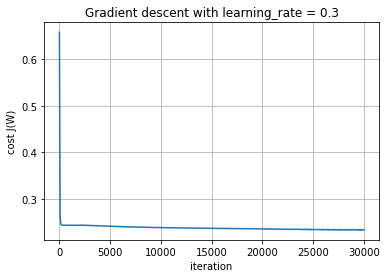

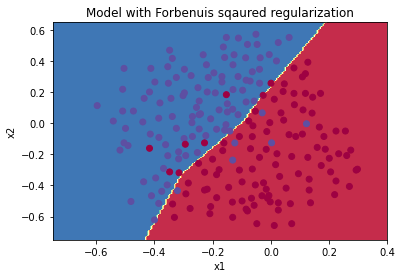

In [30]:
m=m_train
costs = []

for iteration in range(0,30000):


    #Activation Topology:

    Activations=["ReLU","ReLU","Sigmoid"] # L-1 Activations

    ##feedforward wit for: 

    forward = {}
    forward["A" + str(0)] =train_X

    for i in range(1,len(layers_dims)):
        forward["Z" + str(i)] =  parameters["W"+ str(i)].dot(forward["A" + str(i-1)])  + parameters["b"+ str(i)]
        if Activations[i-1] =="ReLU":
            forward["A" + str(i)] = ReLU(forward["Z" + str(i)])
        elif Activations[i-1] == "Sigmoid":
            forward["A" + str(i)] = Sigmoid(forward["Z" + str(i)])

    ###Cost

    # CROSS ENTROPY COST
    logprobs =  train_Y* np.log(forward["A" + str(i)]) + (1-train_Y) * np.log(1- forward["A" + str(i)])
    cost = (-1/m)* np.sum(logprobs)
    
    # (Forbenuis Norm)^2
    forbenuis_2=0
    for i in range(1,int(len(parameters)/2)+1):
        forbenuis_2= forbenuis_2= + np.sum(np.square(parameters["W" +str(i)]))
    forbenuis_2 = (lambd/(2*m))*forbenuis_2
    
    # CROSS ENTROPY + FORBENUIS SQAURED
    
    cost = cost  + forbenuis_2
    costs.append(cost)


    ####Back Prop

    gradiants = {}
     # FORMAL WAY TO COMPUTE GRADIENTS FOR LAST LAYER
    #gradiants["dA" +str(i)] = - (np.divide(train_Y, forward["A" + str(i)]) - np.divide(1 - train_Y, 1 - forward["A" + str(i)]))
    #gradiants["dZ" +str(i)] = gradiants["dA" +str(i)]*dSigmoid(forward["A" + str(i)])
    
    # MUCH FASTER WAY ----->                    Al-Y
    gradiants["dZ" +str(i)] = forward["A" + str(i)] - train_Y

    for i in range(len(layers_dims)-1,0,-1):                                                      # Only change In backprop
        gradiants['W' + str(i)]= 1 / m *gradiants["dZ" +str(i)].dot(forward["A" + str(i-1)].T) + (lambd/m)*parameters["W"+ str(i)]
        gradiants['b' + str(i)]= 1 / m * np.sum(gradiants["dZ" +str(i)], axis=1, keepdims=True)

        if i > 1: #  There is no need to calculate  dA0 and dZ0 (since A0 = inpunt and Z0 does not exist)

            gradiants["dA" +str(i-1)] = parameters["W"+ str(i)].T.dot(gradiants["dZ" +str(i)])
            gradiants["dZ" +str(i-1)] = gradiants["dA" +str(i-1)] * dReLU(forward["Z" + str(i-1)])


    for i in range(len(layers_dims)-1,0,-1): 
        parameters['W' + str(i)]=parameters['W' + str(i)] - learning_rate*gradiants['W' + str(i)]
        parameters['b' + str(i)]=parameters['b' + str(i)] - learning_rate*gradiants['b' + str(i)]


# Meassuring performance

prediction_train=(forward["A" + str(len(layers_dims)-1)] >= 0.5).astype(int)
accuracy_train=(prediction_train==train_Y).astype(int).sum()/m*100
mt=test_X.shape[1]

forward = {}
forward["A" + str(0)] =test_X

for i in range(1,len(layers_dims)):
    forward["Z" + str(i)] =  parameters["W"+ str(i)].dot(forward["A" + str(i-1)])  + parameters["b"+ str(i)]
    if Activations[i-1] =="ReLU":
        forward["A" + str(i)] = ReLU(forward["Z" + str(i)])
    elif Activations[i-1] == "Sigmoid":
        forward["A" + str(i)] = Sigmoid(forward["Z" + str(i)])

prediction_test=(forward["A" + str(len(layers_dims)-1)] >= 0.5).astype(int)
accuracy_test=(prediction_test==test_Y ).astype(int).sum()/mt*100

print(color.BLUE + "Forbenuis sqaured regularization model"+ color.END)

print("\nAccuracy on Train data:",accuracy_train,"%\nAccuaracy on Test data:",accuracy_test,"%")
plt.plot(costs)
plt.title("Gradient descent with learning_rate = {}".format(learning_rate ))
plt.xlabel("iteration")
plt.ylabel("cost J(W)")
plt.grid()
plt.show()

plt.title("Model with Forbenuis sqaured regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

## 3 - Dropout

Finally, **dropout** is a widely used regularization technique that is specific to deep learning. 
**It randomly shuts down some neurons in each iteration.

When you shut some neurons down, you actually modify your model. The idea behind drop-out is that at each iteration, you train a different model that uses only a subset of your neurons. With dropout, your neurons thus become less sensitive to the activation of one other specific neuron, because that other neuron might be shut down at any time.

In [95]:
layers_dims = [train_X.shape[0], 20, 3, 1]
parameters = initialize_parameters_xavier(layers_dims)
print("Neural Net Architecture:",layers_dims)
#Activation Topology:
Activations=["ReLU","ReLU","Sigmoid"] # L-1 Activations

Neural Net Architecture: [2, 20, 3, 1]


In [96]:
learning_rate = 0.3
keep_prob = 0.86

C:\Users\Eduardo\Documents\CARRERA\Udemy\Deep_Learning_Prerequisites_The_Numpy_Stack_in_Python\machine_learning_env\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
C:\Users\Eduardo\Documents\CARRERA\Udemy\Deep_Learning_Prerequisites_The_Numpy_Stack_in_Python\machine_learning_env\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in multiply


Non-regularized model

Accuracy on Train data: 91.9431279620853 %
Accuaracy on Test data: 93.5 %


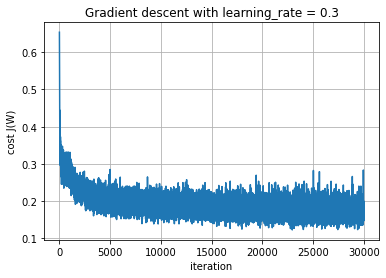

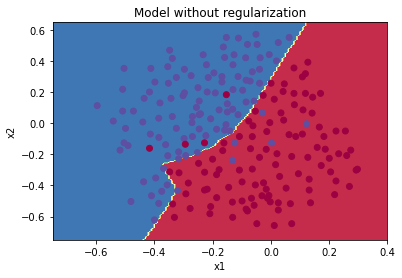

In [97]:
np.random.seed(2)
m=m_train
costs = []
for iteration in range(0,30000):


    ################################################# feedforward wit for: #########################################
    Drop = {}
    forward = {}
    forward["A" + str(0)] =train_X

    for i in range(1,len(layers_dims)):
        
        forward["Z" + str(i)] =  parameters["W"+ str(i)].dot(forward["A" + str(i-1)])  + parameters["b"+ str(i)]
        
        if Activations[i-1] =="ReLU":
            
            # We use RELU For the hidden layers thus we will implement Droput here 
            forward["A" + str(i)] = ReLU(forward["Z" + str(i)])
            Drop["D" + str(i)] = np.random.rand(*forward["A" + str(i)].shape)
            Drop["D" + str(i)] = (Drop["D" + str(i)] < keep_prob).astype(int)
            forward["A" + str(i)] = forward["A" + str(i)]*Drop["D" + str(i)]
            forward["A" + str(i)] =forward["A" + str(i)]/keep_prob
            
        elif Activations[i-1] == "Sigmoid":
            forward["A" + str(i)] = Sigmoid(forward["Z" + str(i)])
     
    
    ################################################# feedforward wit for: #########################################

    ##################################################### Cost #####################################################


    logprobs=np.multiply(-np.log(forward["A" + str(i)]),train_Y) + np.multiply(-np.log(1 - forward["A" + str(i)]), 1 - train_Y)
    cost = (1/m)* np.sum(logprobs)
    costs.append(cost)

    ##################################################### Cost #####################################################

    ######################################   Back Prop ######################################

    gradiants = {}
    # FORMAL WAY TO COMPUTE GRADIENTS FOR LAST LAYER
    #gradiants["dA" +str(i)] = - (np.divide(train_Y, forward["A" + str(i)]) - np.divide(1 - train_Y, 1 - forward["A" + str(i)]))
    #gradiants["dZ" +str(i)] = gradiants["dA" +str(i)]*dSigmoid(forward["A" + str(i)])
    # MUCH FASTER WAY ----->                    Al-Y
    
    # dZL
    gradiants["dZ" +str(i)] = forward["A" + str(i)] - train_Y
    
    # Gradiants for the rest of the network
    for i in range(len(layers_dims)-1,0,-1): 
        gradiants['W' + str(i)]=1. / m *gradiants["dZ" +str(i)].dot(forward["A" + str(i-1)].T)
        gradiants['b' + str(i)]=1. / m * np.sum(gradiants["dZ" +str(i)], axis=1, keepdims=True)

        if i > 1: #  There is no need to calculate  dA0 and dZ0 (since A0 = inpunt and Z0 does not exist)

            gradiants["dA" +str(i-1)] = parameters["W"+ str(i)].T.dot(gradiants["dZ" +str(i)])
            gradiants["dA" +str(i-1)] = gradiants["dA" +str(i-1)]*Drop["D" + str(i-1)]
            gradiants["dA" +str(i-1)] = gradiants["dA" +str(i-1)]/ keep_prob
            gradiants["dZ" +str(i-1)] = gradiants["dA" +str(i-1)] * dReLU(forward["Z" + str(i-1)])
    
    ######################################   Back Prop ######################################
    
    
    ####################################### Gradient Descent ###############################

    for i in range(len(layers_dims)-1,0,-1): 
        parameters['W' + str(i)]=parameters['W' + str(i)] - learning_rate*gradiants['W' + str(i)]
        parameters['b' + str(i)]=parameters['b' + str(i)] - learning_rate*gradiants['b' + str(i)]
    
    ####################################### Gradient Descent ###############################

############################################## Meassuring performance ########################################

############################################ PERFORMANCE IN TRAIN SET ########################################
prediction_train=(forward["A" + str(len(layers_dims)-1)] >= 0.5).astype(int)
accuracy_train=(prediction_train==train_Y).astype(int).sum()/m*100


############################################ PERFORMANCE IN TEST SET ########################################
mt=test_X.shape[1]
forward = {}
forward["A" + str(0)] =test_X

# Feed forward for train set 
for i in range(1,len(layers_dims)):
    forward["Z" + str(i)] =  parameters["W"+ str(i)].dot(forward["A" + str(i-1)])  + parameters["b"+ str(i)]
    if Activations[i-1] =="ReLU":
        forward["A" + str(i)] = ReLU(forward["Z" + str(i)])
    elif Activations[i-1] == "Sigmoid":
        forward["A" + str(i)] = Sigmoid(forward["Z" + str(i)])

prediction_test=(forward["A" + str(len(layers_dims)-1)] >= 0.5).astype(int)
accuracy_test=(prediction_test==test_Y ).astype(int).sum()/mt*100

print(color.BLUE + "Non-regularized model"+ color.END)

# Accuracy
print("\nAccuracy on Train data:",accuracy_train,"%\nAccuaracy on Test data:",accuracy_test,"%")

# Plot Cost
plt.plot(costs)
plt.title("Gradient descent with learning_rate = {}".format(learning_rate ))
plt.xlabel("iteration")
plt.ylabel("cost J(W)")
plt.grid()
plt.show()

#Plot descicion boundary 
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)


**What we want you to remember from this notebook**:
<br>
- Regularization will help you reduce overfitting.
<br>
- Regularization will drive your weights to lower values.
<br>
- L2 regularization and Dropout are two very effective regularization techniques.
<br>